In [14]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

### Basic functions should work as expected

In [3]:
def load_and_show_markers(ann_path: str, raw=None):
    """
    Load markers from annotation file and display them in a table.
    Returns the loaded markers list. If no valid markers found, uses raw data duration.

    The markers are stored as a list of dictionaries with keys:
    'time' (in seconds), 'type', 'description'
    """
    def format_time(time_sec):
        """Convert seconds to MM:SS.mmm format"""
        minutes = int(time_sec // 60)
        seconds = int(time_sec % 60)
        milliseconds = int((time_sec % 1) * 1000)
        return f"{minutes:02d}:{seconds:02d}.{milliseconds:03d}"
    
    markers = []
    
    # Try to load annotations if file exists
    if Path(ann_path).exists():
        with open(ann_path, 'r', encoding='cp1251') as f:
            lines = f.readlines()
            # Skip header
            for line in lines[1:]:  # Skip the first "EventTable V2.0" line
                if line.strip():
                    try:
                        # Typically split by comma
                        parts = line.strip().split(',')
                        if len(parts) >= 2:
                            markers.append({
                                'time': float(parts[0]) / 1000.0,  # Convert to seconds from ms
                                'type': parts[1],
                                'description': parts[3] if len(parts) > 3 else ''
                            })
                    except (ValueError, IndexError):
                        print(f"Skipping invalid line: {line.strip()}")
                        continue
    
    # Display table
    print("\nMarker Index Reference Table:")
    print("-" * 50)
    print(f"{'Index':<8} {'Time':<12} {'Description':<30}")
    print("-" * 50)
    
    # Show start of file
    print(f"0        00:00.000    Start of file")
    
    # Show all markers if any exist
    for i, marker in enumerate(markers, 1):
        time_str = format_time(marker['time'])
        print(f"{i:<8} {time_str:<12} Marker {i}")
    
    # Show end of file using raw data duration
    if raw is not None:
        duration = raw.times[-1]  # Get actual duration from raw data
    else:
        print("Warning: No raw data provided to determine file duration")
        return []
        
    end_time_str = format_time(duration)
    print(f"{len(markers)+1:<8} {end_time_str:<12} End of file")
    print("-" * 50)
    
    return markers

In [4]:
def load_experiment_files(folder_path: str):
    """
    Load .edf, .ann, and .ini files from the specified folder.
    Returns raw (mne.io.Raw) and markers (list of dict).
    """
    folder = Path(folder_path)
    
    # Find files with matching names but different extensions
    edf_files = list(folder.glob("*.edf"))
    if not edf_files:
        raise FileNotFoundError("No .edf files found in the specified folder")
    
    # Take the first .edf file and use its stem to find corresponding files
    base_name = edf_files[0].stem
    
    edf_path = folder / f"{base_name}.edf"
    ann_path = folder / f"{base_name}.ann"
    ini_path = folder / f"{base_name}.ini"
    
    # Load EDF file
    raw = mne.io.read_raw_edf(edf_path, preload=True)
    
    # Load markers and show table
    markers = load_and_show_markers(ann_path, raw)
    
    return raw, markers

In [5]:
def extract_marked_data(raw, markers, start_index, end_index, epoch_duration=4.0, overlap=3.0):
    """
    Extract data between specified marker indices and split into overlapping epochs.
    Indices: 0 = file start, 1..n = markers, n+1 = file end.
    """
    # Get total duration of the recording
    total_duration = raw.times[-1]
    
    # Create list of all possible time points (start, markers, end)
    time_points = [0.0] + [m['time'] for m in markers] + [total_duration]
    
    # Validate indices
    if start_index < 0 or end_index > len(time_points)-1:
        raise ValueError(f"Indices must be between 0 and {len(time_points)-1}")
    if start_index >= end_index:
        raise ValueError("Start index must be less than end index")
    
    # Get start and end times based on indices
    start_time = time_points[start_index]
    end_time = time_points[end_index]
    
    # Process data
    epochs_data = []
    sfreq = raw.info['sfreq']
    samples_per_epoch = int(epoch_duration * sfreq)
    samples_per_overlap = int(overlap * sfreq)
    step_size = samples_per_epoch - samples_per_overlap
    
    # Convert times to samples
    start_sample = int(start_time * sfreq)
    end_sample = int(end_time * sfreq)
    
    # Extract data segment
    segment_data, _ = raw[:, start_sample:end_sample]
    
    # Create overlapping epochs
    n_epochs = (segment_data.shape[1] - samples_per_epoch) // step_size + 1
    for j in range(n_epochs):
        start_idx = j * step_size
        end_idx = start_idx + samples_per_epoch
        if end_idx <= segment_data.shape[1]:
            epochs_data.append(segment_data[:, start_idx:end_idx])
    
    return np.array(epochs_data)

In [6]:
def plot_averaged_epochs(epochs_data, raw, epoch_duration=4.0):
    """
    Average epochs and plot results for each electrode.
    """
    # Average across epochs
    averaged_data = np.mean(epochs_data, axis=0)
    
    # Create time array for x-axis
    time_points = np.linspace(0, epoch_duration, averaged_data.shape[1])
    
    # Plot each channel
    n_channels = averaged_data.shape[0]
    fig, axes = plt.subplots(n_channels, 1, figsize=(15, 3*n_channels))
    
    if n_channels == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        ax.plot(time_points, averaged_data[i], 'b-')
        ax.set_title(f'Channel {raw.ch_names[i]}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

In [7]:
def plot_spectrograms(epochs_data, raw, epoch_duration=4.0):
    """
    Compute and plot averaged spectrograms for each channel.
    """
    from scipy import signal
    
    sfreq = raw.info['sfreq']
    n_channels = epochs_data.shape[1]
    
    # Parameters for spectrogram
    nperseg = int(sfreq)  # 1-second window
    noverlap = nperseg // 2  # 50% overlap
    
    # Create subplot for each channel
    fig, axes = plt.subplots(n_channels, 1, figsize=(15, 4*n_channels))
    if n_channels == 1:
        axes = [axes]
    
    for ch_idx in range(n_channels):
        # Average spectrogram across epochs
        avg_spectrogram = None
        
        for epoch in epochs_data:
            frequencies, times, Sxx = signal.spectrogram(
                epoch[ch_idx], 
                fs=sfreq,
                nperseg=nperseg,
                noverlap=noverlap,
                window='hann'
            )
            
            if avg_spectrogram is None:
                avg_spectrogram = Sxx
            else:
                avg_spectrogram += Sxx
        
        avg_spectrogram /= len(epochs_data)
        
        # Plot
        im = axes[ch_idx].pcolormesh(times, frequencies, 10 * np.log10(avg_spectrogram),
                                     shading='gouraud', cmap='viridis')
        axes[ch_idx].set_ylabel('Frequency [Hz]')
        axes[ch_idx].set_title(f'Channel {raw.ch_names[ch_idx]}')
        
        cbar = plt.colorbar(im, ax=axes[ch_idx])
        cbar.set_label('Power/Frequency [dB/Hz]')
        
        axes[ch_idx].set_ylim(0, 50)
    
    axes[-1].set_xlabel('Time [s]')
    plt.tight_layout()
    plt.show()

In [8]:
def plot_power_spectrum(epochs_data, raw, epoch_duration=4.0):
    """
    Compute and plot averaged power spectrum (FFT) for each channel.
    Display up to 30 Hz and amplitude range 0-7 µV.
    """
    sfreq = raw.info['sfreq']
    n_channels = epochs_data.shape[1]
    
    n_points = epochs_data.shape[2]
    freq_axis = np.fft.rfftfreq(n_points, d=1/sfreq)
    
    fig, axes = plt.subplots(n_channels, 1, figsize=(15, 4*n_channels))
    if n_channels == 1:
        axes = [axes]
    
    for ch_idx in range(n_channels):
        # Average FFT across epochs
        avg_spectrum = np.zeros_like(freq_axis, dtype=float)
        
        for epoch in epochs_data:
            windowed_data = epoch[ch_idx] * np.hanning(len(epoch[ch_idx]))
            spectrum = np.abs(np.fft.rfft(windowed_data)) * 2.0 / n_points
            avg_spectrum += spectrum
        
        avg_spectrum /= len(epochs_data)
        
        axes[ch_idx].plot(freq_axis, avg_spectrum)
        axes[ch_idx].set_xlabel('Frequency [Hz]')
        axes[ch_idx].set_ylabel('Amplitude [µV]')
        axes[ch_idx].set_title(f'Channel {raw.ch_names[ch_idx]}')
        axes[ch_idx].set_xlim(0, 30)
        axes[ch_idx].set_ylim(0, 7)
        axes[ch_idx].grid(True)
        
        # Frequency bands
        bands = {
            'delta': (0.5, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30)
        }
        
        y_pos = 6.5
        for band, (fmin, fmax) in bands.items():
            axes[ch_idx].axvspan(fmin, fmax, alpha=0.2, color='gray')
            axes[ch_idx].text((fmin + fmax)/2, y_pos, band, 
                              horizontalalignment='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()


### New functions

In [9]:
def insert_marker(markers, time, marker_type='User', description=''):
    """
    Insert a new marker into the markers list at the specified time.
    The markers list should remain sorted by time.
    This does not modify any file, only the markers object in memory.
    
    Parameters:
    - markers: list of dicts with keys ['time', 'type', 'description']
    - time: float, time in seconds for the new marker
    - marker_type: str, type of the new marker
    - description: str, description of the new marker
    """
    new_marker = {'time': time, 'type': marker_type, 'description': description}
    # Insert maintaining order
    inserted = False
    for i, m in enumerate(markers):
        if time < m['time']:
            markers.insert(i, new_marker)
            inserted = True
            break
    if not inserted:
        markers.append(new_marker)
    return markers

In [28]:
def plot_amplitude_maps(epochs_data, raw, epoch_duration=4.0, max_val=-1):
    """
    Create topographic maps of amplitude distribution for all standard frequency bands.
    Normalizes the sum of amplitudes within each band by the number of frequency bins.
    
    Parameters:
    - epochs_data: np.array [n_epochs, n_channels, n_points]
    - raw: mne.io.Raw object
    - epoch_duration: float, duration of each epoch in seconds
    - max_val: float, if -1 then auto-scale per band, otherwise fixed max amplitude.
      If fixed, the scale will go from 0 to max_val for each band.
    
    Changes made:
    2.1) Check calculations: 
         Previously we did amplitude as abs(FFT)*2/n_points. This is a standard amplitude calculation.
         Other software might differ, but let's keep this standard. The difference might be due to normalization.
         We will keep the same logic but add comments.
    2.2) Implement the amplitude range parameter (max_val). If max_val=-1, auto adjust based on min/max of data.
    2.3) Adjust figure layout so the head is larger within the figure.
    
    We'll rely on MNE's plot_topomap defaults for scaling. We'll remove fixed vlim and 
    specify vlim dynamically based on the data if max_val = -1.
    """
    import mne
    
    # Define frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 7),
        'alpha': (7, 14),
        'beta': (13, 20),
        'beta-2': (20, 30),
        'alpha-1': (7, 9),
        'alpha-2': (9, 11.5),
        'alpha-3': (11.5, 14)
    }
    
    # Define standard 10-20 system approximate coordinates if needed
    # User must ensure raw channels match these names. If not, adjust code accordingly.
    ch_pos = {
        'EEG Fp1': [-0.308, 0.851],
        'EEG Fp2': [0.308, 0.851],
        'EEG F3': [-0.5, 0.526],
        'EEG Fz': [0, 0.526],
        'EEG F4': [0.5, 0.526],
        'EEG C3': [-0.736, 0],
        'EEG Cz': [0, 0],
        'EEG C4': [0.736, 0],
        'EEG T3': [-0.8, 0],
        'EEG T4': [0.8, 0],
        'EEG P3': [-0.5, -0.526],
        'EEG Pz': [0, -0.526],
        'EEG P4': [0.5, -0.526],
        'EEG O1': [-0.308, -0.851],
        'EEG O2': [0.308, -0.851],
    }
    
    sfreq = raw.info['sfreq']
    n_points = epochs_data.shape[2]
    freq_axis = np.fft.rfftfreq(n_points, d=1/sfreq)
    
    # Pick only EEG channels present in ch_pos
    # Filter channels that we have positions for
    eeg_picks = [idx for idx, name in enumerate(raw.ch_names) if name in ch_pos]
    eeg_ch_names = [raw.ch_names[idx] for idx in eeg_picks]
    pos = np.array([ch_pos[name] for name in eeg_ch_names])
    
    # Compute amplitude for each band and channel
    # We'll sum amplitude across epochs, average after
    window = np.hanning(n_points)
    
    for band_name, freq_band in bands.items():
        amplitude_values = np.zeros(len(eeg_picks))
        
        for i, ch_idx in enumerate(eeg_picks):
            total_spectrum = np.zeros_like(freq_axis, dtype=float)
            for epoch in epochs_data:
                windowed_data = epoch[ch_idx] * window
                spectrum = np.abs(np.fft.rfft(windowed_data)) * 2.0 / n_points
                total_spectrum += spectrum
            # Average across epochs
            total_spectrum /= len(epochs_data)
            
            # Extract frequencies within the band
            freq_mask = (freq_axis >= freq_band[0]) & (freq_axis <= freq_band[1])
            amplitude_sum = np.sum(total_spectrum[freq_mask])
            num_bins = np.sum(freq_mask)
            if num_bins > 0:
                amplitude_values[i] = amplitude_sum / num_bins
        
        # Determine vlim
        if max_val == -1:
            vlim = (np.min(amplitude_values), np.max(amplitude_values))
        else:
            vlim = (0, max_val)
        
        # Plot topomap
        # Adjust figure size and parameters to make the head bigger
        fig, ax = plt.subplots(figsize=(5, 5))
        im, cn = mne.viz.plot_topomap(amplitude_values, pos,
                                      cmap='RdBu_r', sensors=True,
                                      contours=6, outlines='head',
                                      vlim=vlim,
                                      axes=ax, show=False,
                                      sphere=1.0)  # sphere controls the head size; adjust if needed
        
        plt.title(f'{band_name.capitalize()} ({freq_band[0]}-{freq_band[1]} Hz)', fontsize=14, pad=20)
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Amplitude (µV)', fontsize=12)
        
        plt.tight_layout()
        plt.show()

In [11]:
def clean_data_with_ica(raw, eog_channels=None, emg_channels=None, n_components=20, random_state=42):
    """
    Perform ICA to remove EOG and EMG artifacts from the data.
    This is a heuristic approach:
    - Identify EOG related components if eog_channels are provided (horizontal and vertical EOG).
    - Identify EMG related components if emg_channels are provided.
    
    Parameters:
    - raw: mne.io.Raw object
    - eog_channels: list of str, names of EOG channels
    - emg_channels: list of str, names of EMG channels
    - n_components: int, number of ICA components
    - random_state: int, for reproducibility
    
    The function modifies the raw object by removing artifact components.
    """
    # Filtering is often recommended before ICA
    # Here we assume raw is already band-pass filtered or at least prepared.
    
    # Fit ICA
    ica = mne.preprocessing.ICA(n_components=n_components, random_state=random_state)
    ica.fit(raw)
    
    # Find and remove EOG components
    if eog_channels is not None:
        eog_inds, scores = ica.find_bads_eog(raw, ch_name=eog_channels)
        ica.exclude.extend(eog_inds)
    
    # Find and remove EMG components
    # MNE doesn't have a direct find_bads_emg, but we can try:
    # MNE does have find_bads_ecg, but EMG is trickier.
    # A rough approach: high frequency components might be EMG.
    # Alternatively, use ICA component inspection to identify EMG.
    # For demonstration, if emg_channels are given, we try find_bads_eog as a placeholder
    # or we can rely on correlation with EMG channels if present.
    if emg_channels is not None:
        # Method: Correlate ICA sources with EMG envelope and pick high correlation
        # This is a heuristic approach.
        emg_data = raw.get_data(picks=emg_channels)
        emg_envelope = np.abs(emg_data).mean(axis=0)
        
        # Get ICA sources
        ica_sources = ica.get_sources(raw).get_data()
        # Correlate each component with EMG envelope
        corrs = [np.corrcoef(ica_sources[i], emg_envelope)[0,1] for i in range(ica_sources.shape[0])]
        # Threshold correlation to find EMG components
        # EMG correlation threshold: somewhat arbitrary, say >0.3
        emg_inds = [i for i, c in enumerate(corrs) if np.abs(c) > 0.3]
        ica.exclude.extend(emg_inds)
    
    # Apply ICA
    ica.apply(raw)
    return raw

In [38]:
def view_eeg(raw, markers):
    """
    View EEG data in a widget with sliders for time scale, window position, and amplification.
    Each channel should be about 100 pixels high.
    Markers should be shown as vertical lines.
    Channel names are shown on the left side.
    
    Requirements:
    - ipywidgets for interactive display in a Jupyter notebook.
    - This function won't work in a non-notebook environment.
    
    Parameters:
    - raw: mne.io.Raw
    - markers: list of dict with 'time', 'type', 'description'
    """
    from ipywidgets import interact, FloatSlider, IntSlider
    import IPython.display as display
    
    sfreq = raw.info['sfreq']
    data = raw.get_data()
    ch_names = raw.ch_names
    n_channels = len(ch_names)
    total_duration = raw.times[-1]
    
    # Default parameters
    default_timescale = 5.0  # 5 seconds window
    default_position = 0.0
    default_amplification = 1.0  # no scaling
    
    max_duration = total_duration
    
    def plot_data(time_scale, window_start, amplification):
        fig = plt.figure(figsize=(15, n_channels*1))  # height = n_channels * 1 inch approx
        ax = fig.add_subplot(111)
        
        # Compute sample start and end
        start_sample = int(window_start * sfreq)
        end_sample = int((window_start + time_scale) * sfreq)
        if end_sample > data.shape[1]:
            end_sample = data.shape[1]
        
        t = np.arange(start_sample, end_sample) / sfreq
        
        # Plot each channel
        offset = 0
        spacing = 100  # pixels scale doesn't directly translate, but let's mimic a vertical offset
        for i in range(n_channels):
            channel_data = data[i, start_sample:end_sample] * amplification
            plt.plot(t, channel_data + offset, 'k')
            # Add channel names on the left side
            plt.text(window_start - (time_scale * 0.05), offset, ch_names[i], 
                    ha='right', va='center')
            offset -= spacing
        
        # Plot markers within this time window as vertical lines
        for m in markers:
            if m['time'] >= window_start and m['time'] <= (window_start + time_scale):
                plt.axvline(m['time'], color='r', linestyle='--')
                plt.text(m['time'], offset + spacing*(1), f"{m['type']}", 
                        color='r', rotation=90, va='bottom')
        
        plt.xlabel('Time (s)')
        plt.title('EEG Data Viewer')
        plt.ylim(offset - spacing, 100)  # some margin
        plt.xlim(window_start, window_start+time_scale)
        plt.grid(True)
        
        # Hide y-axis numbers but keep the axis line
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        
        plt.show()
    
    time_scale_slider = FloatSlider(value=default_timescale, min=1.0, max=30.0, 
                                  step=0.5, description='Time Scale (s)')
    window_start_slider = FloatSlider(value=default_position, min=0.0, 
                                    max=max_duration-1, step=0.1, 
                                    description='Window Start (s)')
    amplification_slider = FloatSlider(value=default_amplification, min=0.1, 
                                     max=10.0, step=0.1, 
                                     description='Amplification')
    
    interact(plot_data, time_scale=time_scale_slider, 
            window_start=window_start_slider, 
            amplification=amplification_slider)

In [60]:
def compare_power_spectra(freq_axis, spectrum1, spectrum2, name1="First condition", name2="Second condition"):
    """
    Compare two power spectra arrays and plot their difference.
    difference = spectrum1 - spectrum2.
    Areas above 0 shaded in blue, areas below 0 shaded in red.

    Parameters:
    - freq_axis: array of frequency values
    - spectrum1: array of amplitude values (first spectrum)
    - spectrum2: array of amplitude values (second spectrum)
    - name1: str, name of the first condition
    - name2: str, name of the second condition
    """
    diff = spectrum1 - spectrum2

    plt.figure(figsize=(10, 4))
    plt.plot(freq_axis, diff, 'k-', label=f'{name1} vs {name2}')
    plt.axhline(0, color='grey', linewidth=1)
    plt.fill_between(freq_axis, diff, where=(diff > 0), color='blue', alpha=0.2, 
                     label=f'Higher in {name1}')
    plt.fill_between(freq_axis, diff, where=(diff < 0), color='red', alpha=0.2,
                     label=f'Higher in {name2}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Difference in Amplitude')
    plt.title(f'Spectrum Difference: {name1} vs {name2}')
    plt.grid(True)
    plt.legend()
    plt.xlim(0, 30)
    plt.show()

### Usage

In [53]:
FOLDER_PATH = "ЭЭГ Ира/проба1_закртые глаза"  # Replace with your path
EPOCH_DURATION = 4.0  # seconds
OVERLAP = 3.0  # seconds

raw, markers = load_experiment_files(FOLDER_PATH)
epochs_data = extract_marked_data(raw, markers, start_index=1, end_index=128,
                                   epoch_duration=EPOCH_DURATION, overlap=OVERLAP)
# plot_averaged_epochs(epochs_data, raw, epoch_duration=4.0)


# # Comparing two spectra:
# # Suppose we have two spectra avg_spectrum1 and avg_spectrum2 from different conditions
# # compare_power_spectra(freq_axis, avg_spectrum1, avg_spectrum2)

Extracting EDF parameters from c:\Users\timof\Downloads\EEG_data\ЭЭГ Ира\проба1_закртые глаза\глаза закрыты.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181919  =      0.000 ...   181.919 secs...

Marker Index Reference Table:
--------------------------------------------------
Index    Time         Description                   
--------------------------------------------------
0        00:00.000    Start of file
1        00:53.182    Marker 1
2        00:53.182    Marker 2
3        00:54.207    Marker 3
4        00:55.231    Marker 4
5        00:56.255    Marker 5
6        00:57.279    Marker 6
7        00:58.302    Marker 7
8        00:59.326    Marker 8
9        01:00.350    Marker 9
10       01:01.375    Marker 10
11       01:02.399    Marker 11
12       01:03.423    Marker 12
13       01:04.447    Marker 13
14       01:05.471    Marker 14
15       01:06.495    Marker 15
16       01:07.519    Marker 16
17       01:08.543  

C:\Users\timof\AppData\Local\Temp\ipykernel_5372\724120377.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
C:\Users\timof\AppData\Local\Temp\ipykernel_5372\724120377.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


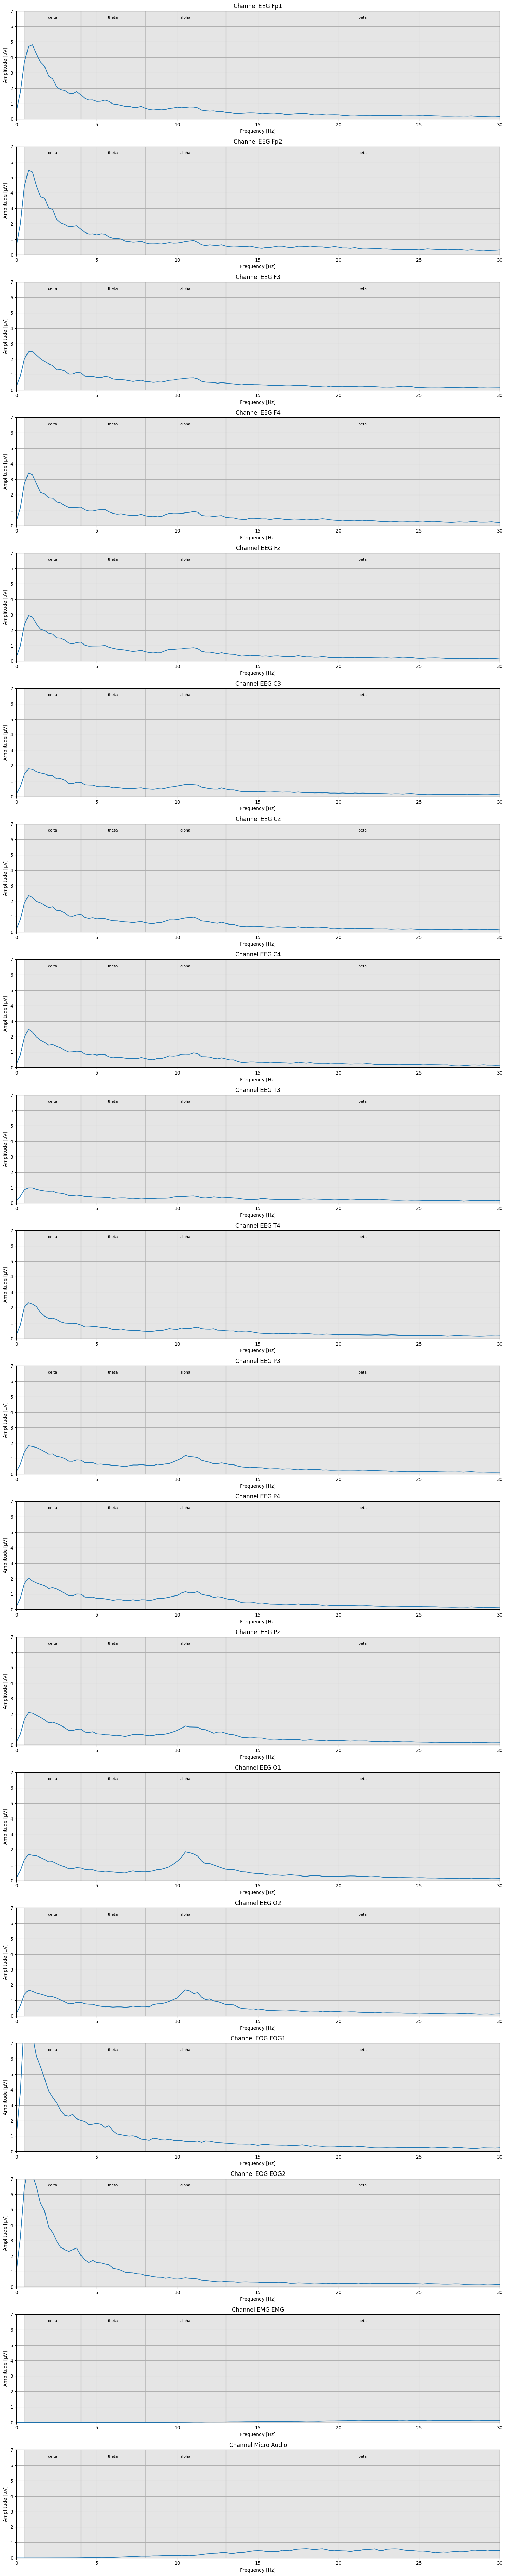

In [54]:
plot_power_spectrum(epochs_data, raw, EPOCH_DURATION)

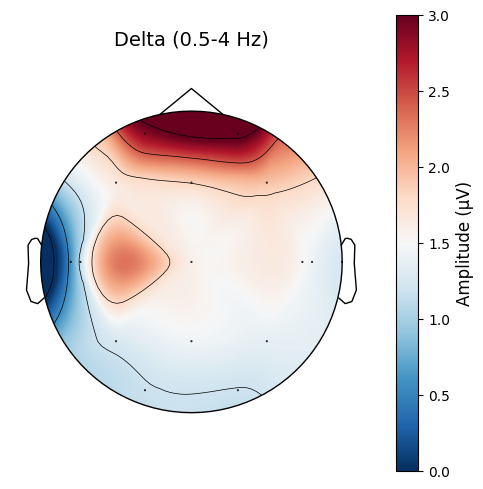

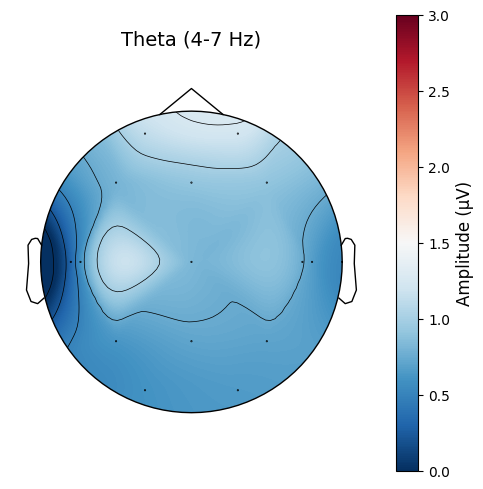

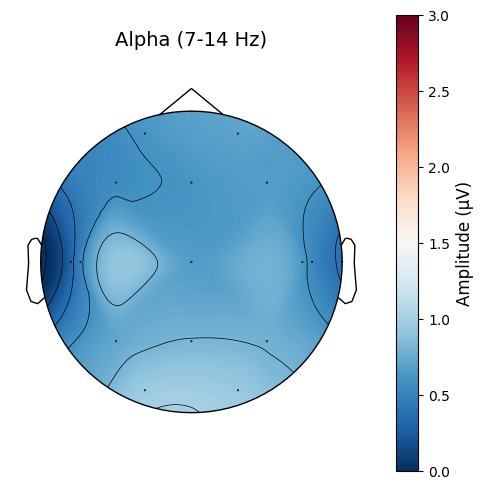

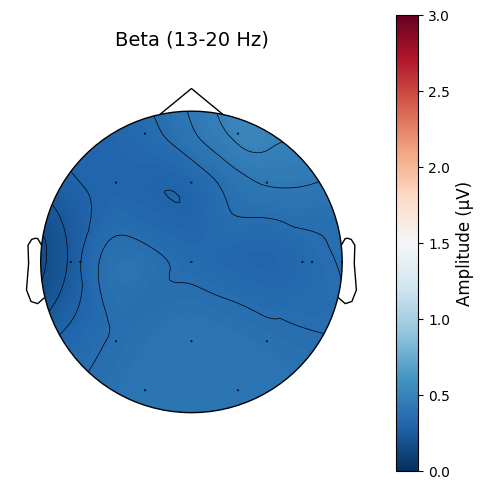

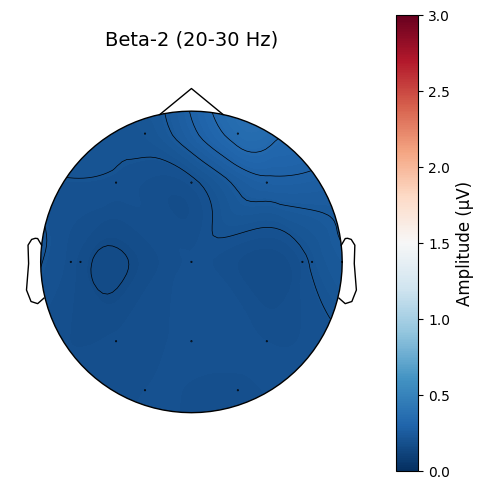

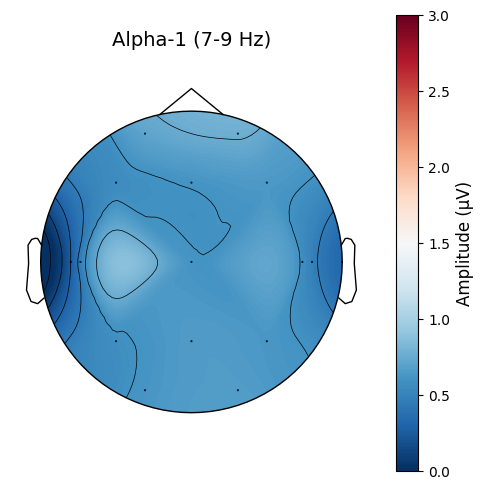

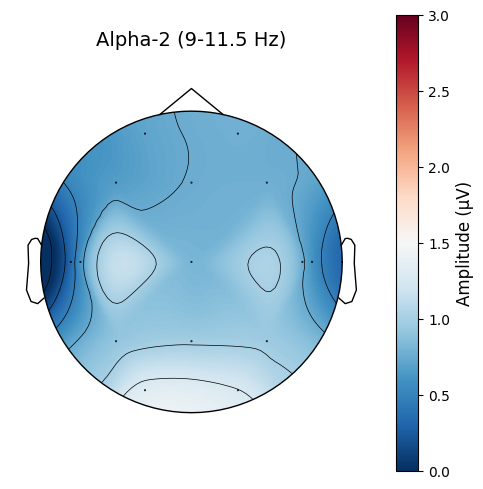

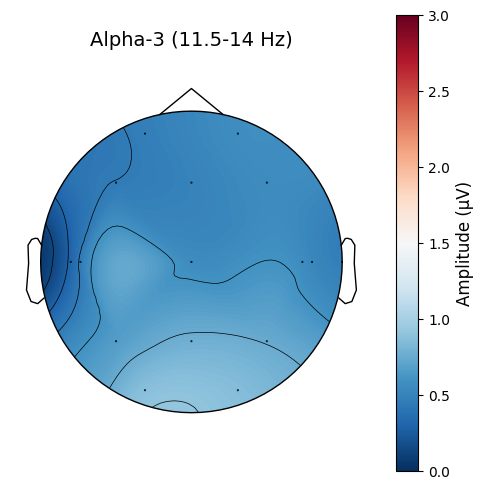

In [55]:
plot_amplitude_maps(epochs_data, raw, epoch_duration=4.0, max_val=3)

In [43]:
view_eeg(raw, markers)

interactive(children=(FloatSlider(value=5.0, description='Time Scale (s)', max=30.0, min=1.0, step=0.5), Float…

Extracting EDF parameters from c:\Users\timof\Downloads\EEG_data\ЭЭГ Ира\проба1_закртые глаза\глаза закрыты.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181919  =      0.000 ...   181.919 secs...

Marker Index Reference Table:
--------------------------------------------------
Index    Time         Description                   
--------------------------------------------------
0        00:00.000    Start of file
1        00:53.182    Marker 1
2        00:53.182    Marker 2
3        00:54.207    Marker 3
4        00:55.231    Marker 4
5        00:56.255    Marker 5
6        00:57.279    Marker 6
7        00:58.302    Marker 7
8        00:59.326    Marker 8
9        01:00.350    Marker 9
10       01:01.375    Marker 10
11       01:02.399    Marker 11
12       01:03.423    Marker 12
13       01:04.447    Marker 13
14       01:05.471    Marker 14
15       01:06.495    Marker 15
16       01:07.519    Marker 16
17       01:08.543  

C:\Users\timof\AppData\Local\Temp\ipykernel_5372\724120377.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
C:\Users\timof\AppData\Local\Temp\ipykernel_5372\724120377.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


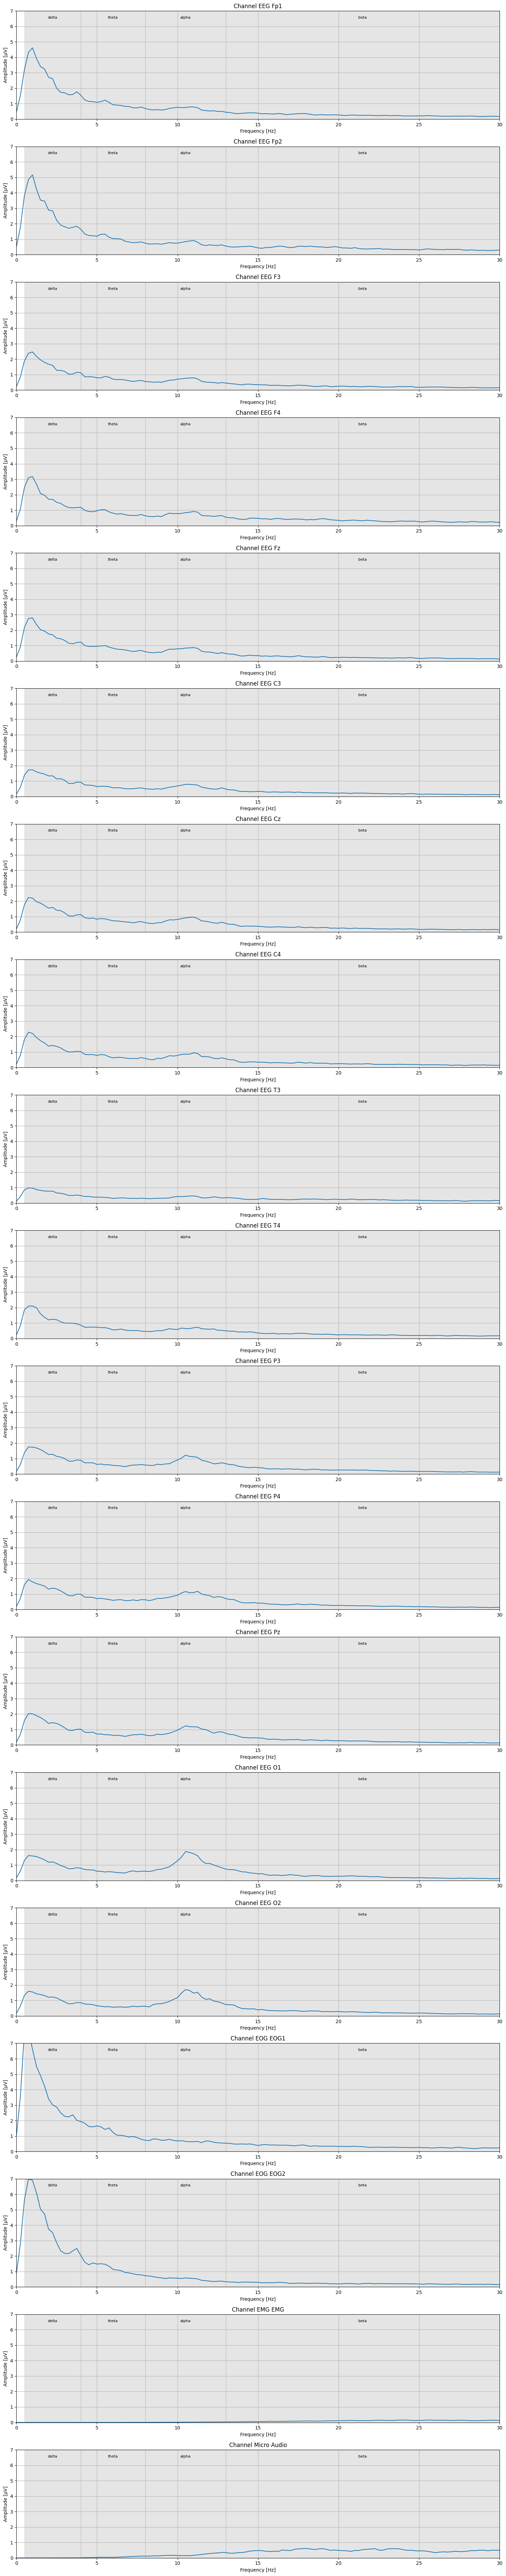

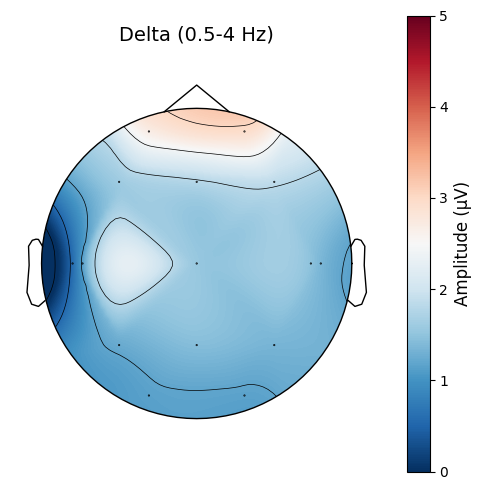

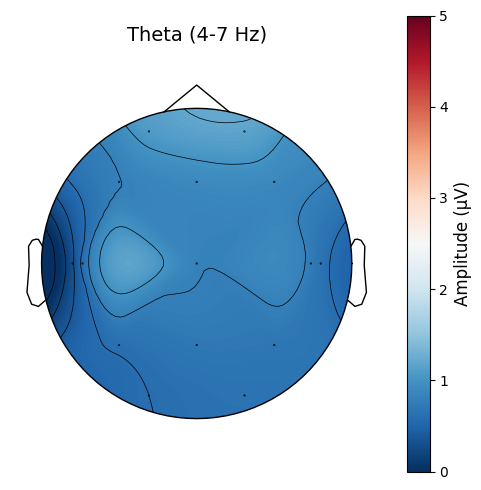

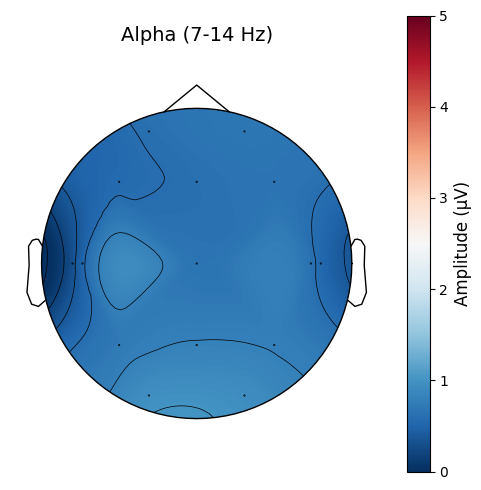

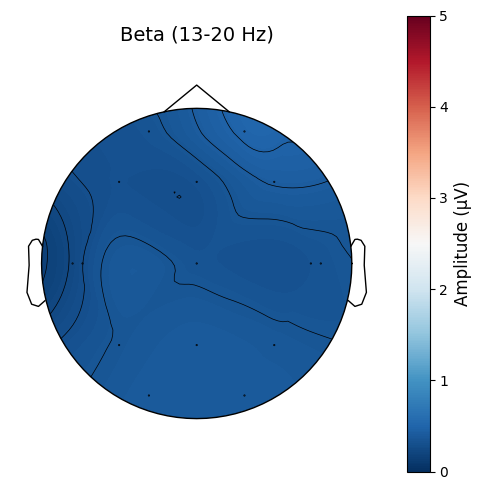

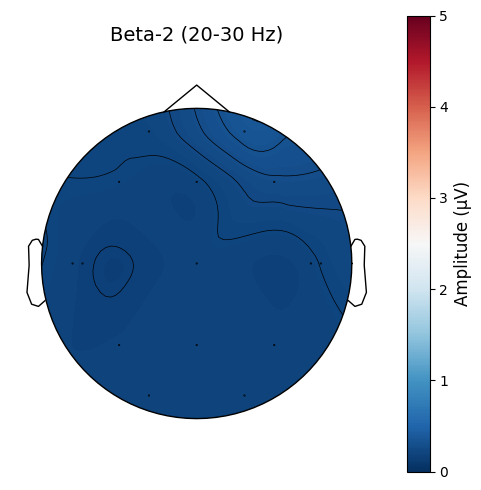

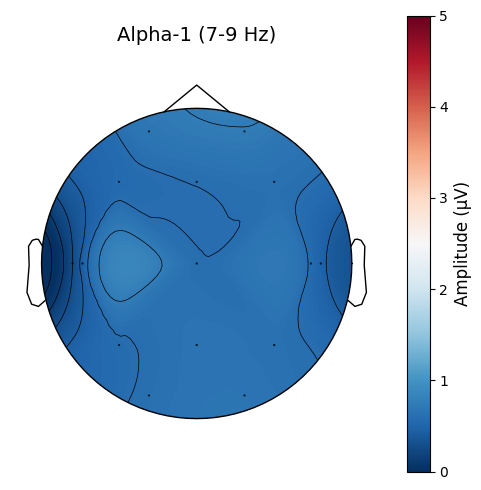

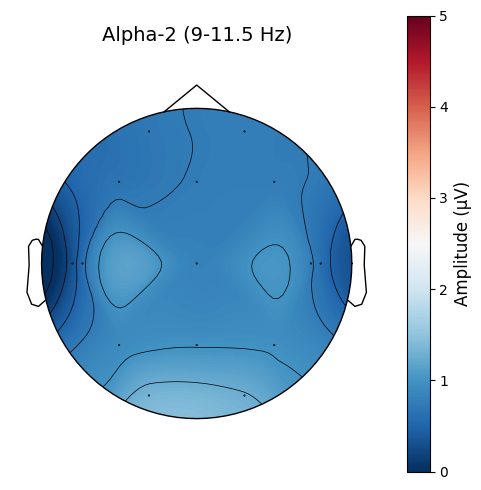

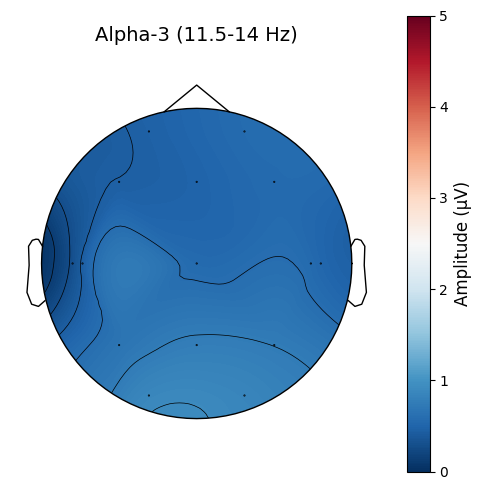

In [56]:
FOLDER_PATH = "ЭЭГ Ира\проба1_закртые глаза"
raw, markers = load_experiment_files(FOLDER_PATH)
epochs_data = extract_marked_data(raw, markers, 1, 127, 4.0, 3.0)
plot_power_spectrum(epochs_data, raw, 4.0)
plot_amplitude_maps(epochs_data, raw, epoch_duration=4.0, max_val=5)

Extracting EDF parameters from c:\Users\timof\Downloads\EEG_data\ЭЭГ Ира\проба1_закртые глаза\глаза закрыты.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 181919  =      0.000 ...   181.919 secs...

Marker Index Reference Table:
--------------------------------------------------
Index    Time         Description                   
--------------------------------------------------
0        00:00.000    Start of file
1        00:53.182    Marker 1
2        00:53.182    Marker 2
3        00:54.207    Marker 3
4        00:55.231    Marker 4
5        00:56.255    Marker 5
6        00:57.279    Marker 6
7        00:58.302    Marker 7
8        00:59.326    Marker 8
9        01:00.350    Marker 9
10       01:01.375    Marker 10
11       01:02.399    Marker 11
12       01:03.423    Marker 12
13       01:04.447    Marker 13
14       01:05.471    Marker 14
15       01:06.495    Marker 15
16       01:07.519    Marker 16
17       01:08.543  

C:\Users\timof\AppData\Local\Temp\ipykernel_5372\724120377.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
C:\Users\timof\AppData\Local\Temp\ipykernel_5372\724120377.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


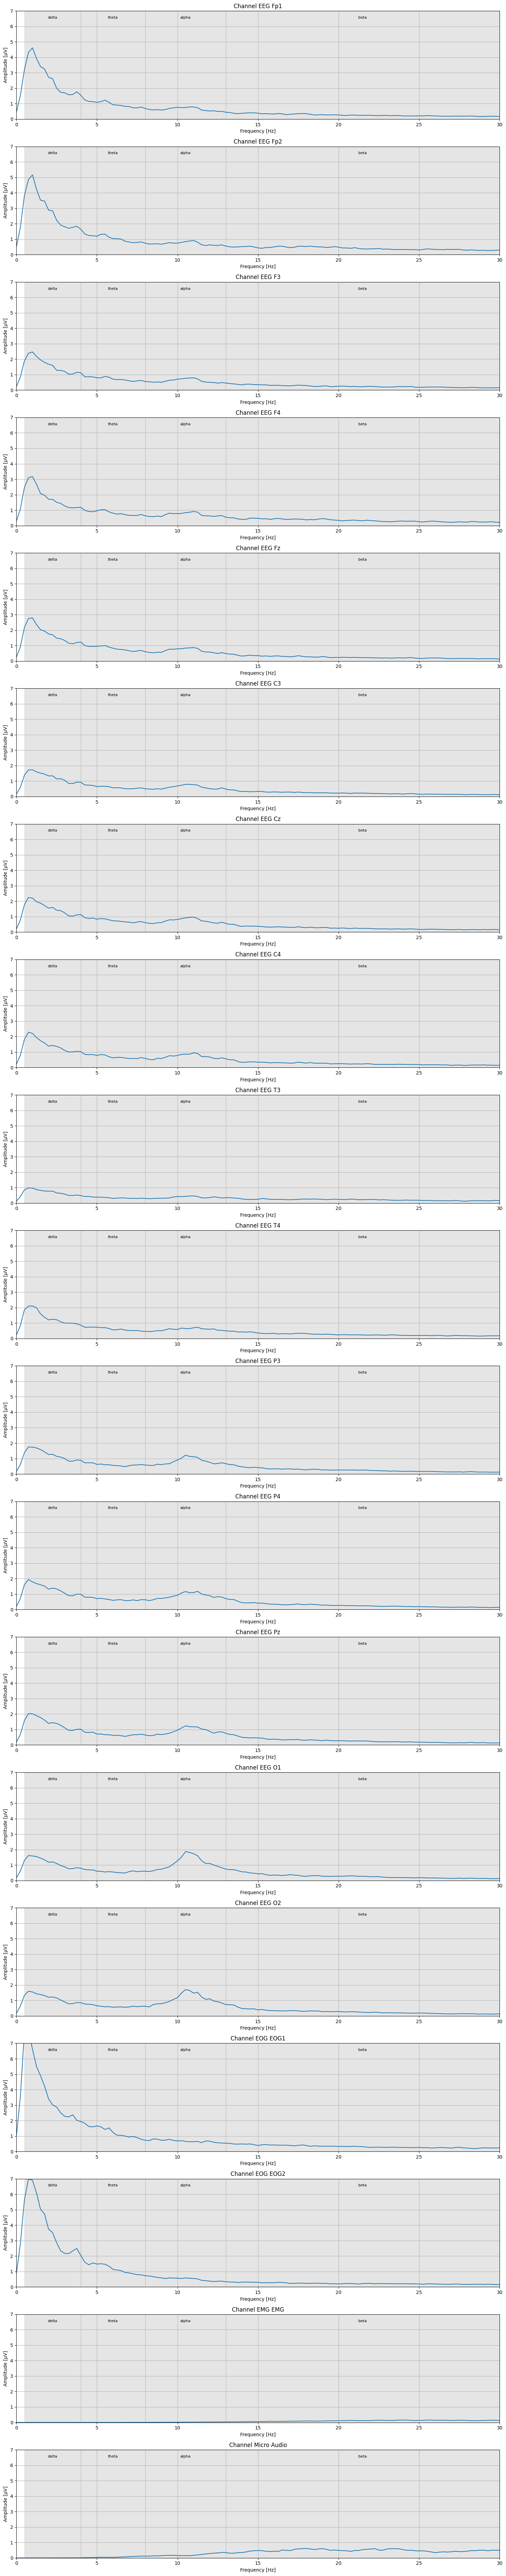

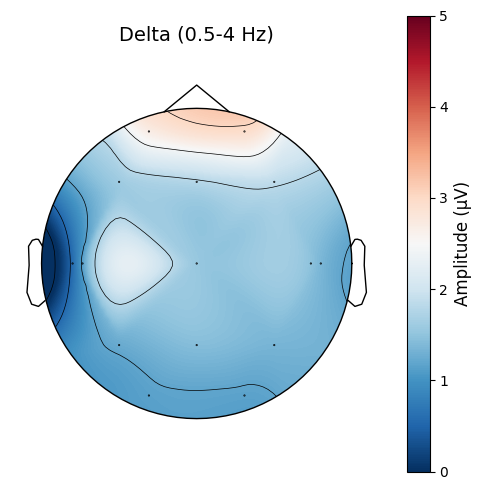

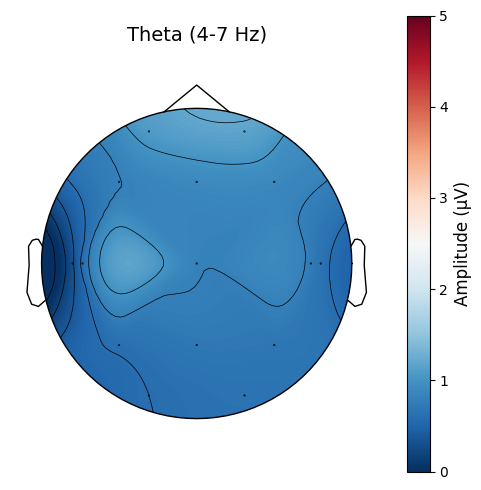

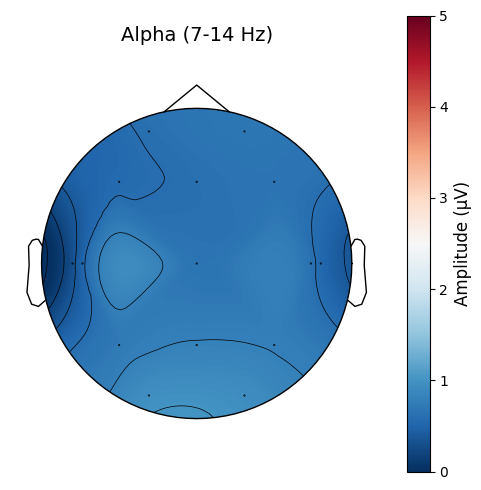

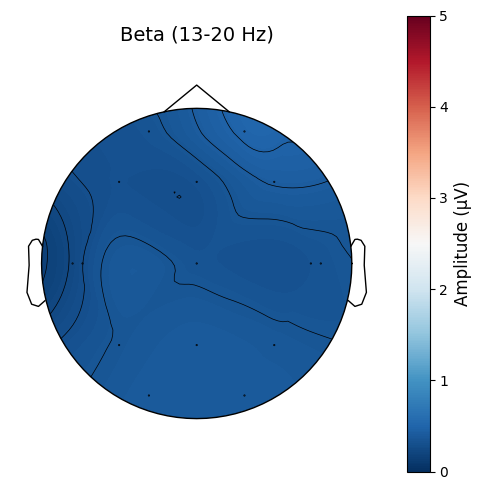

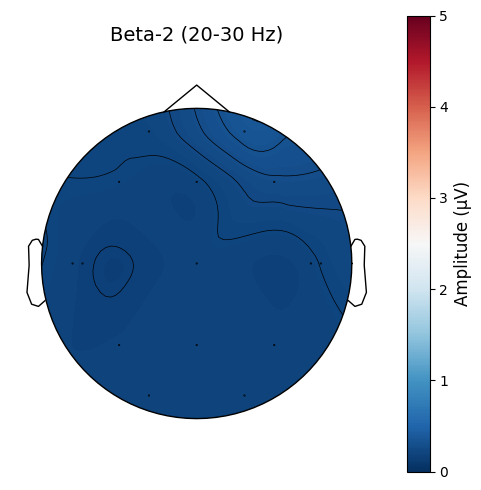

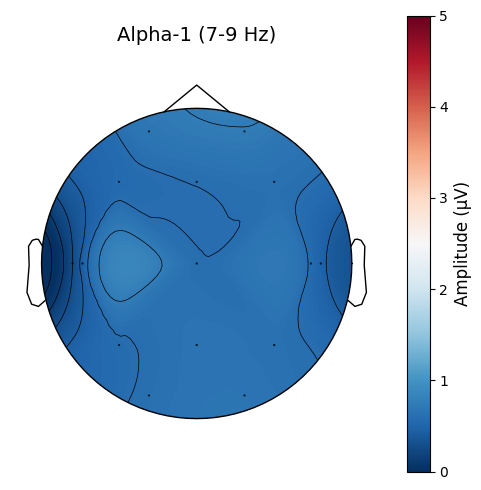

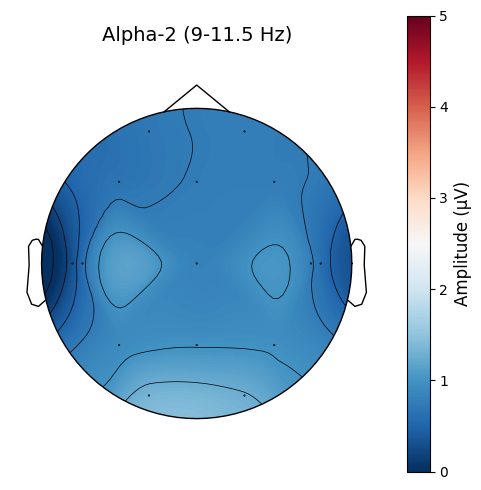

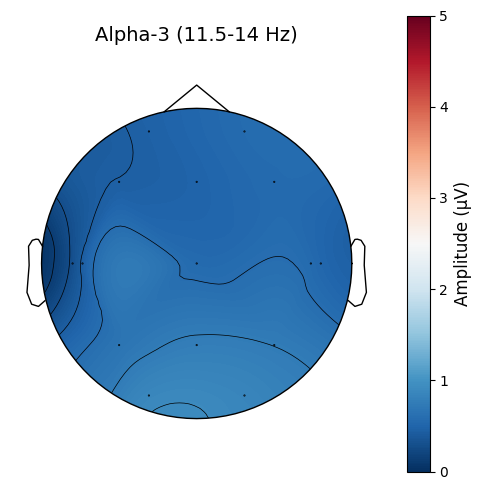

Extracting EDF parameters from c:\Users\timof\Downloads\EEG_data\ЭЭГ Ира\медитация\медитация чилл.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 736079  =      0.000 ...   736.079 secs...

Marker Index Reference Table:
--------------------------------------------------
Index    Time         Description                   
--------------------------------------------------
0        00:00.000    Start of file


C:\Users\timof\AppData\Local\Temp\ipykernel_5372\724120377.py:21: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
C:\Users\timof\AppData\Local\Temp\ipykernel_5372\724120377.py:21: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


1        12:16.078    End of file
--------------------------------------------------


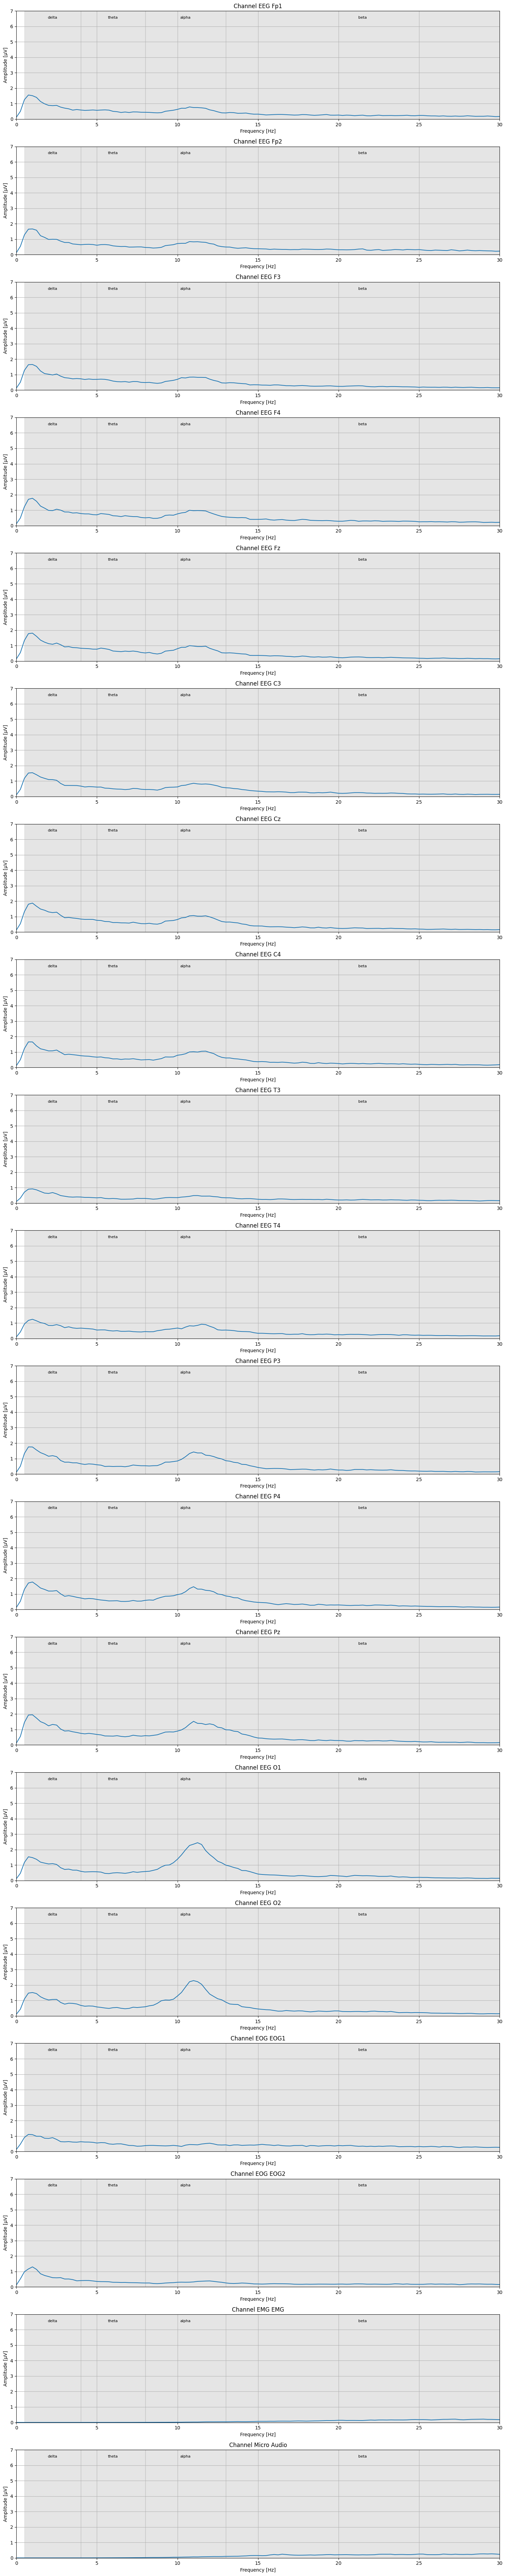

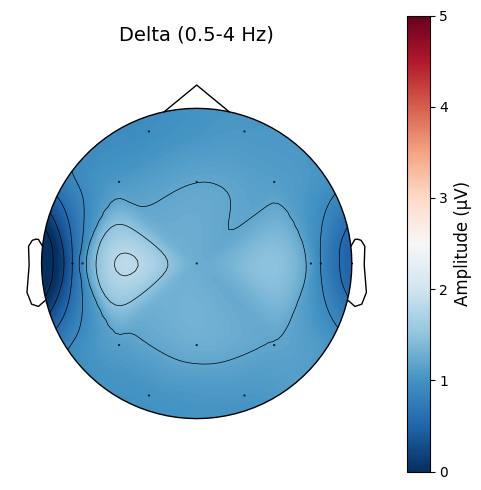

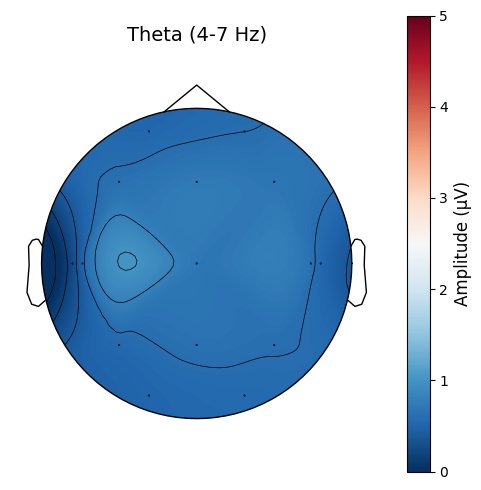

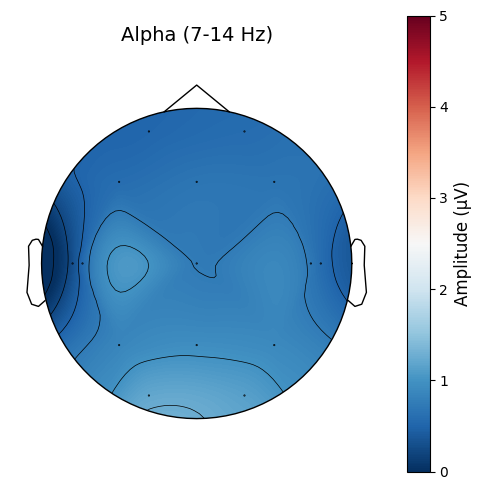

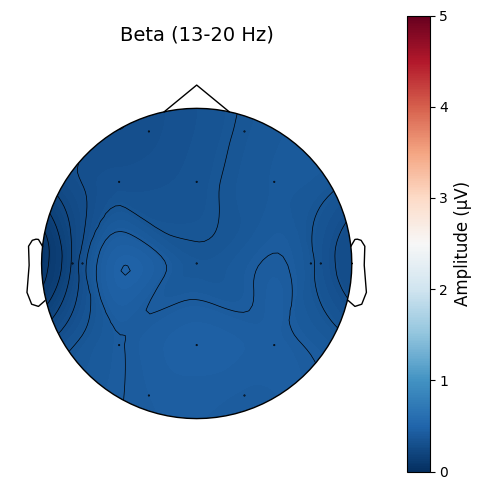

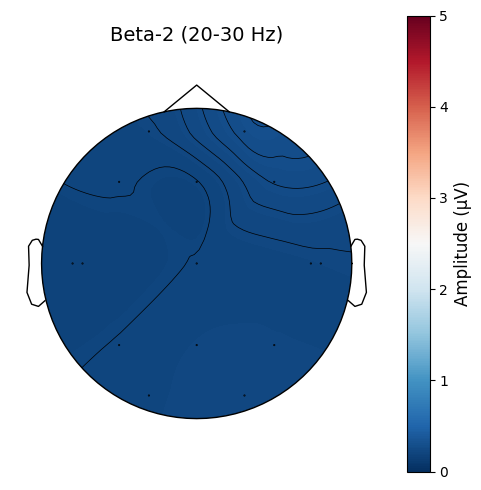

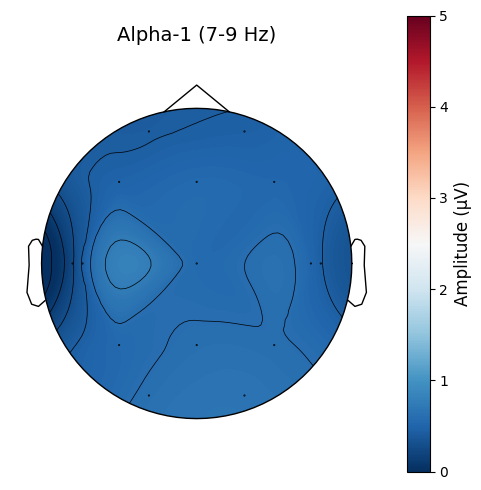

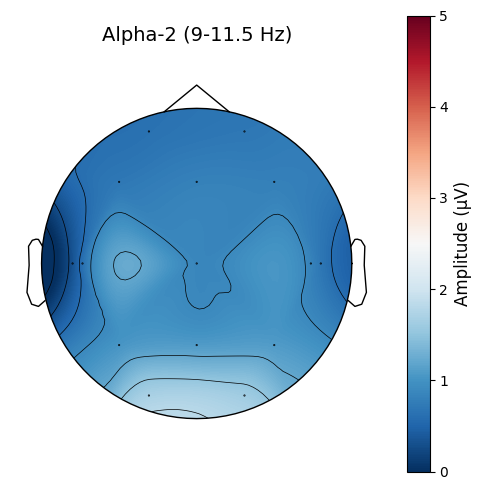

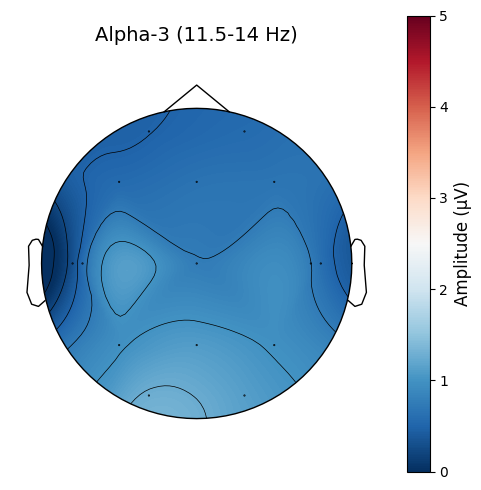

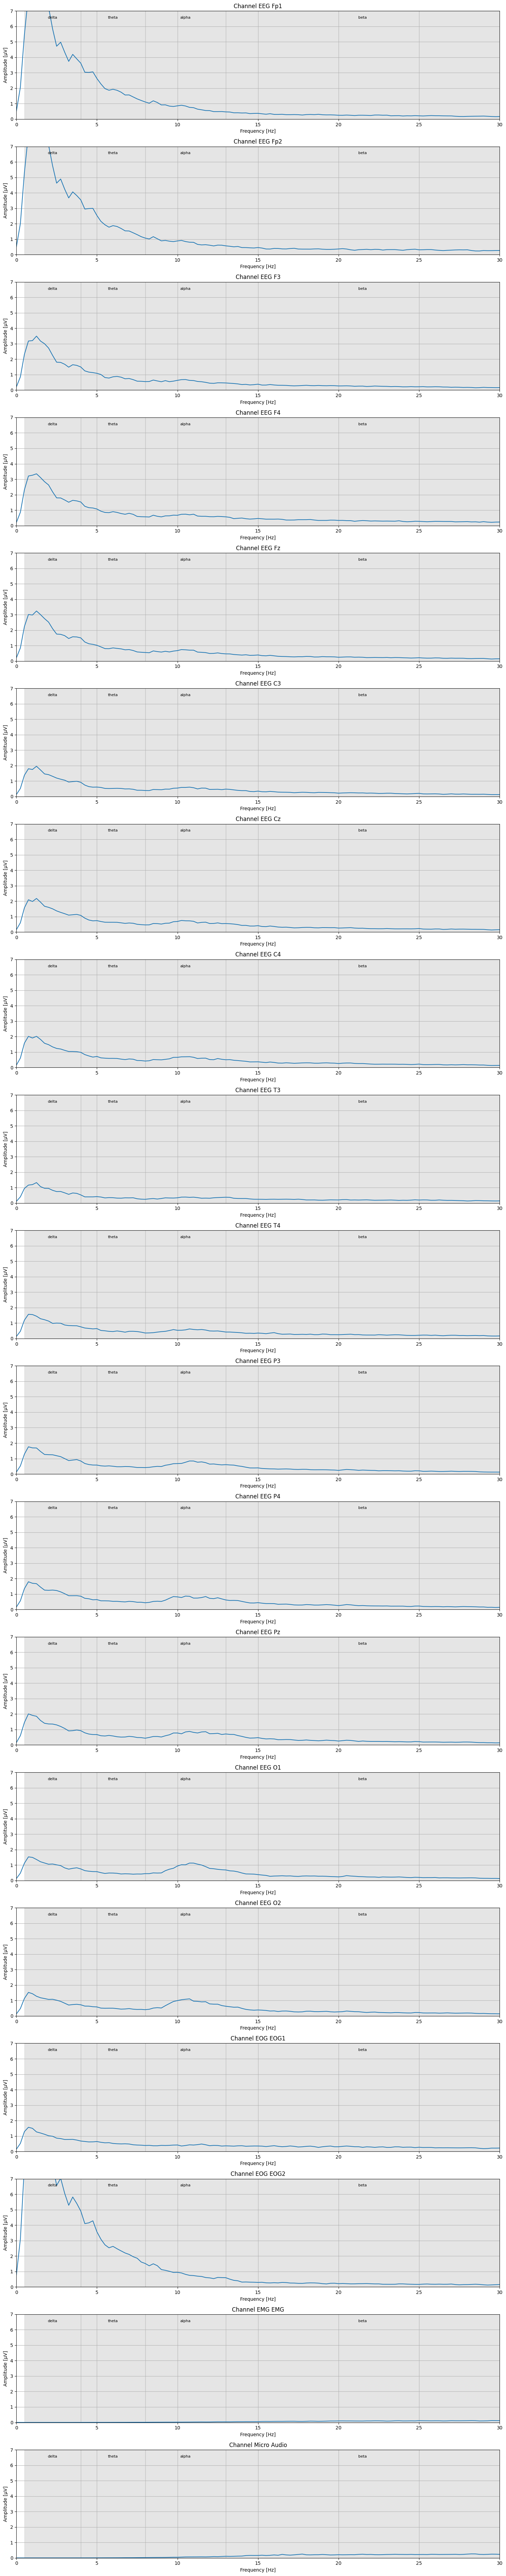

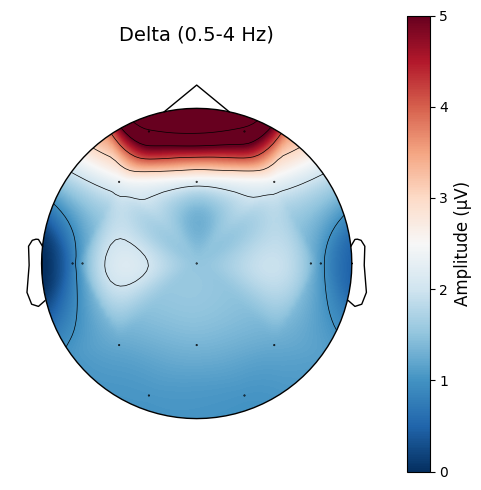

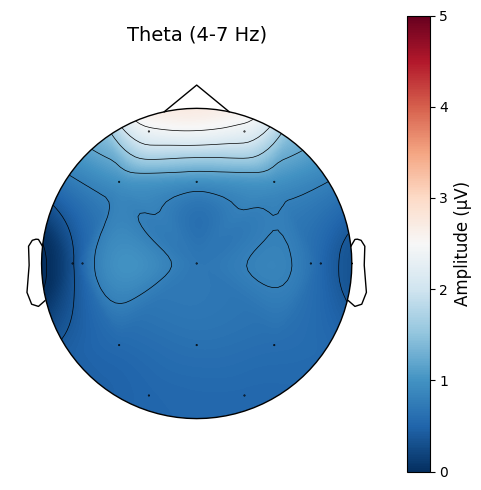

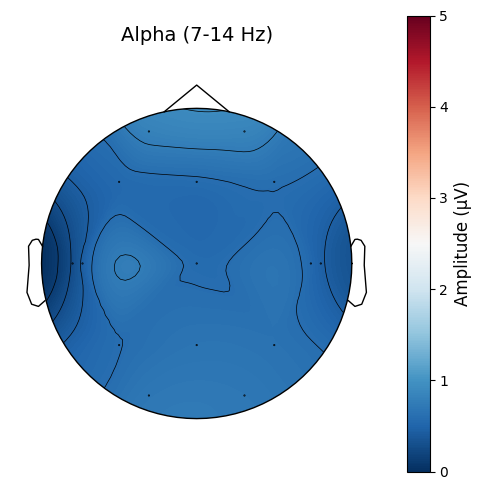

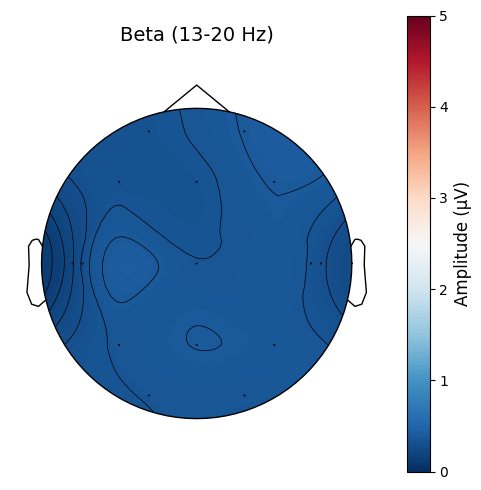

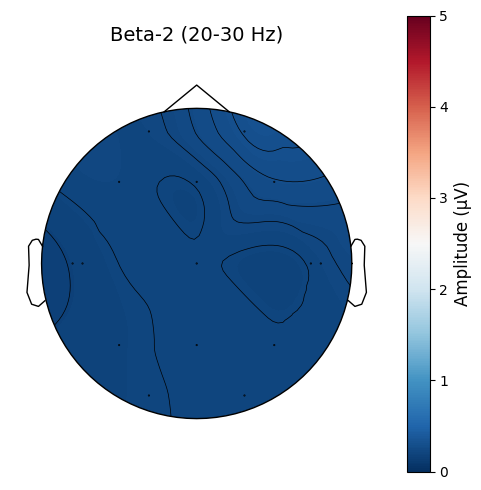

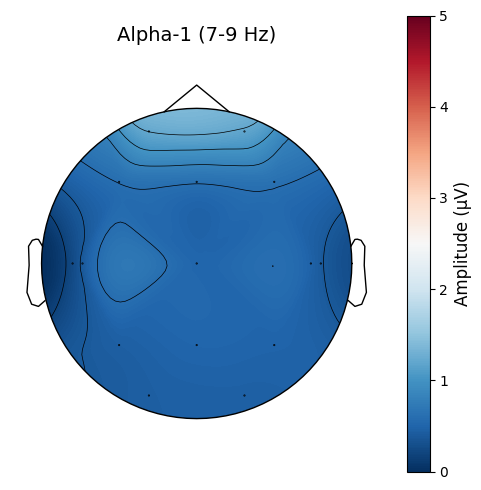

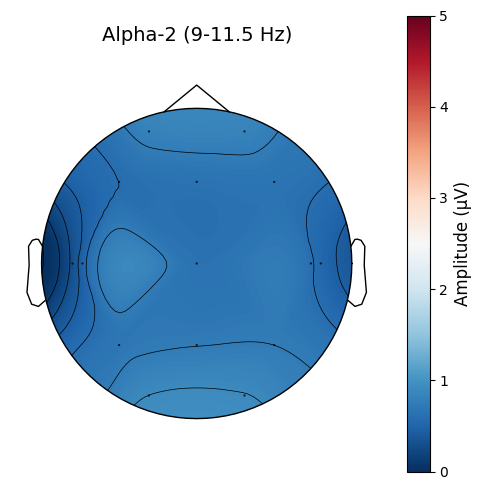

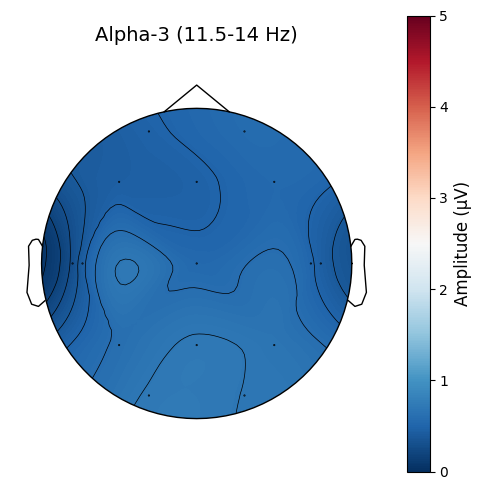

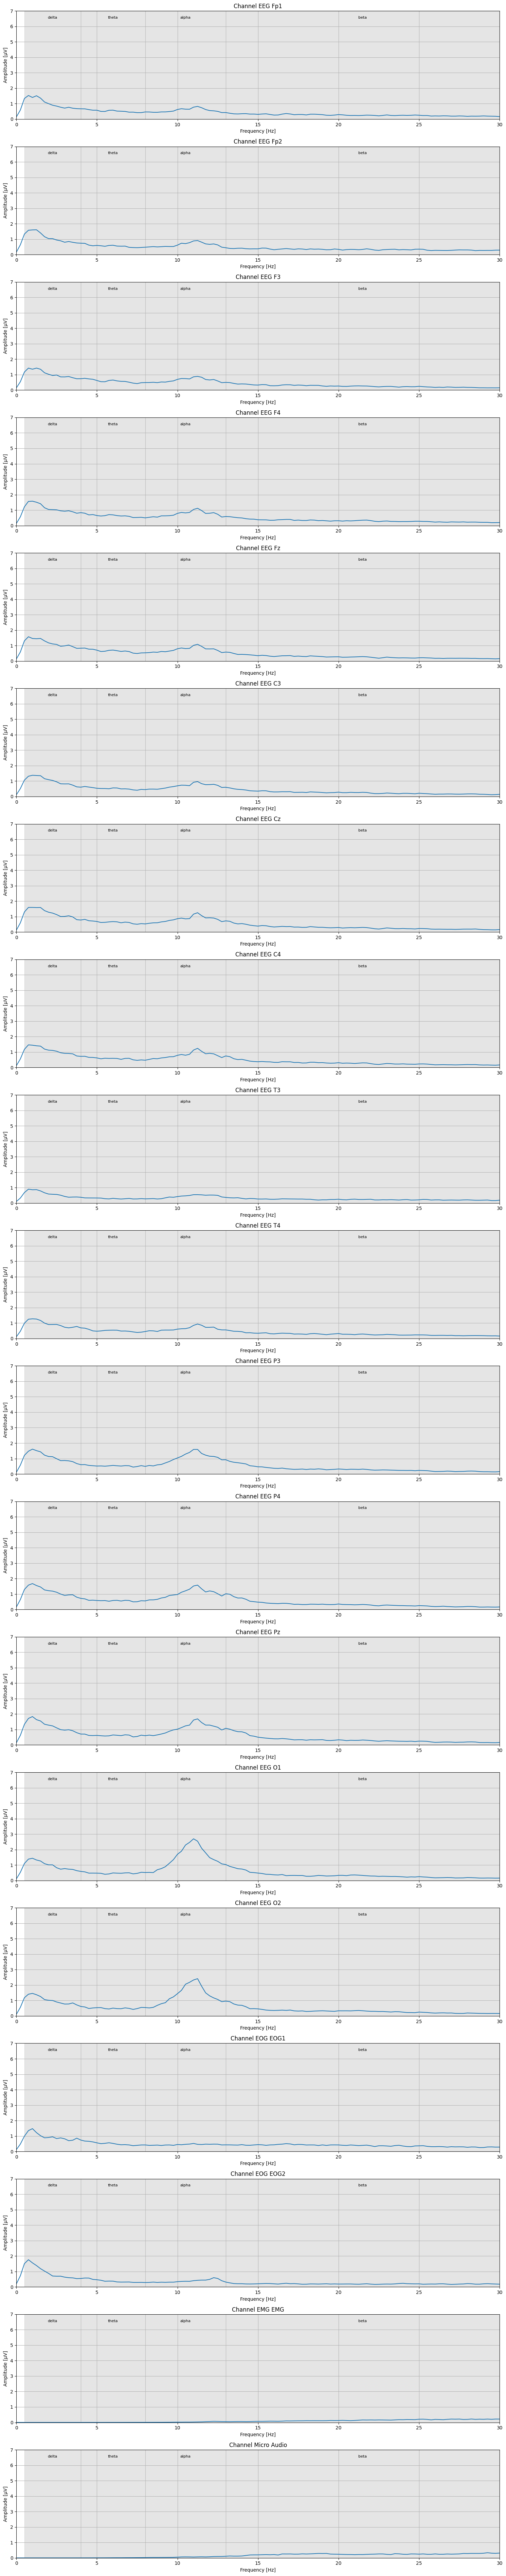

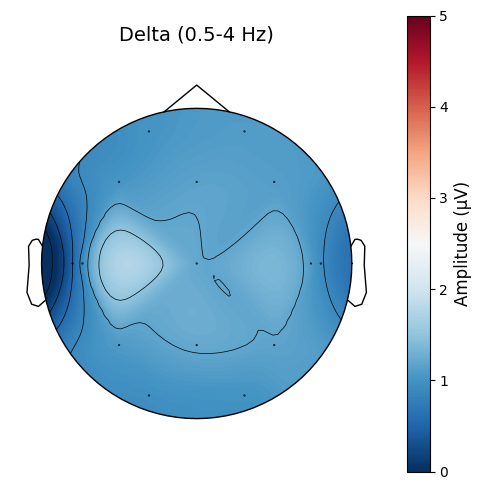

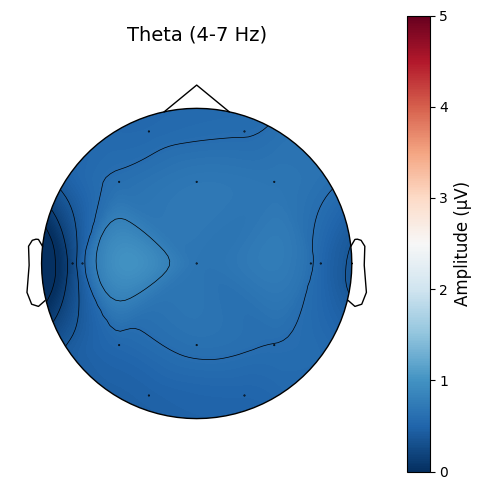

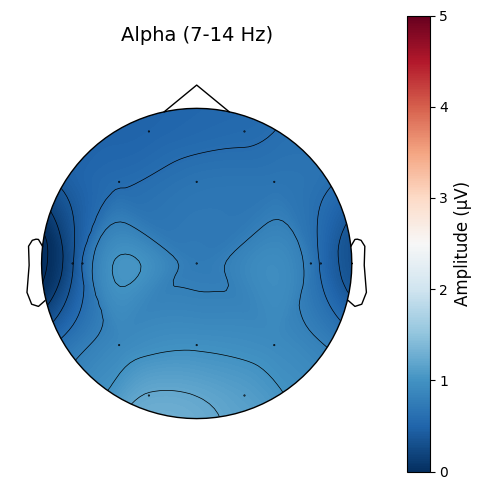

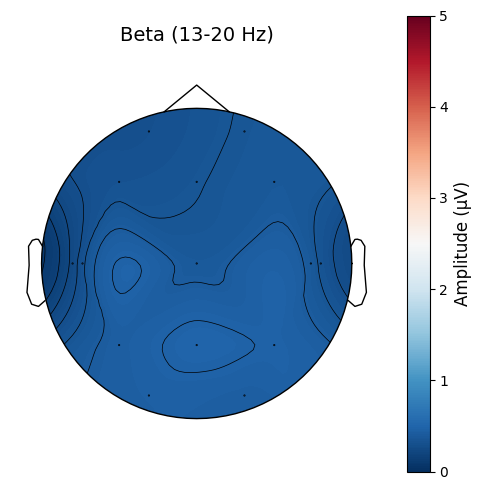

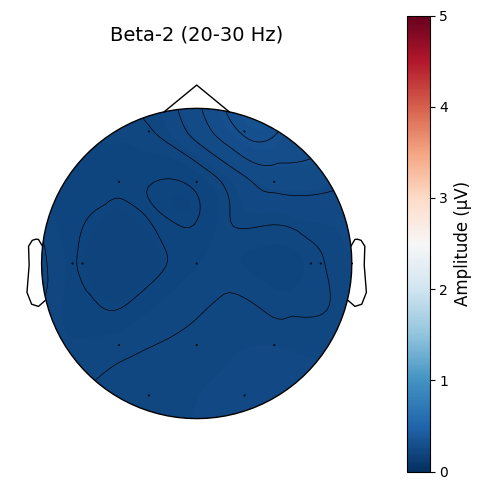

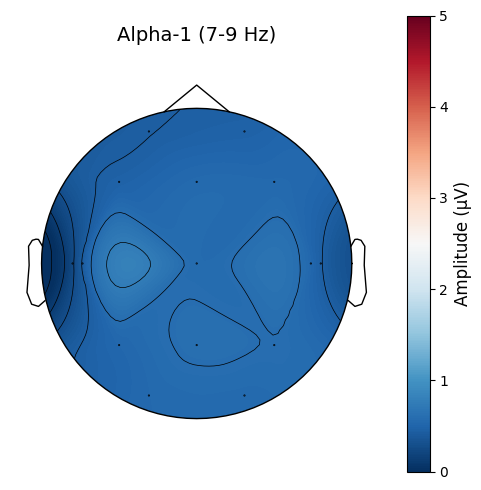

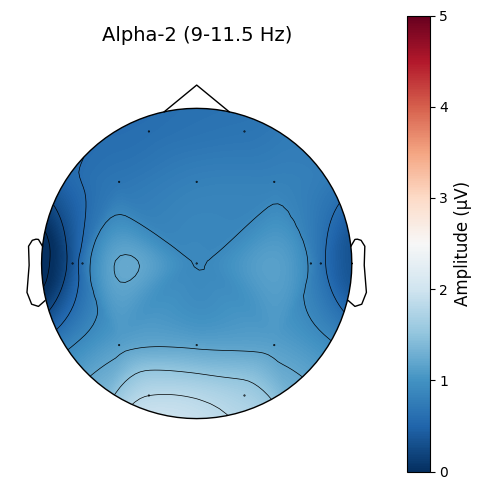

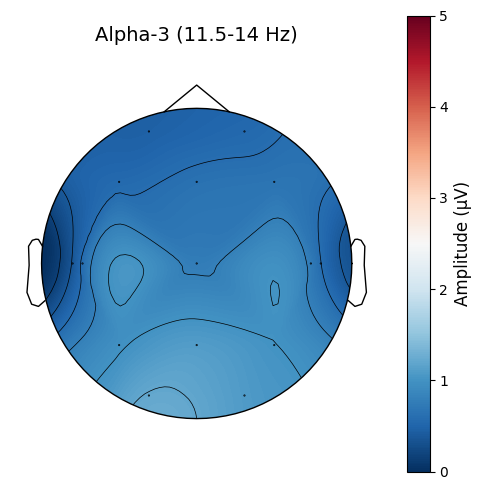

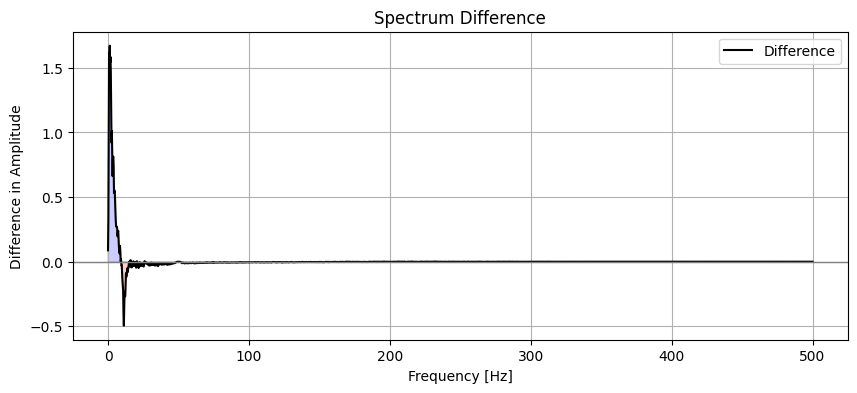

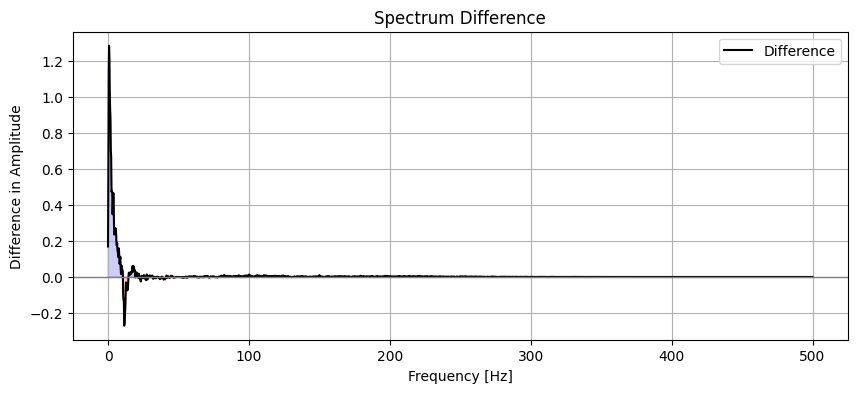

In [58]:
# Для пробы1
FOLDER_PATH = "ЭЭГ Ира\проба1_закртые глаза"
raw, markers = load_experiment_files(FOLDER_PATH)
epochs_data = extract_marked_data(raw, markers, 1, 127, 4.0, 3.0)
plot_power_spectrum(epochs_data, raw, 4.0)
plot_amplitude_maps(epochs_data, raw, epoch_duration=4.0, max_val=5)

# Сохраняем спектр пробы1
n_points = epochs_data.shape[2]
sfreq = raw.info['sfreq']
freq_axis = np.fft.rfftfreq(n_points, d=1/sfreq)
avg_spectrum_probe1 = np.zeros_like(freq_axis)
for epoch in epochs_data:
    for ch_idx in range(epochs_data.shape[1]):
        windowed_data = epoch[ch_idx] * np.hanning(len(epoch[ch_idx]))
        spectrum = np.abs(np.fft.rfft(windowed_data)) * 2.0 / n_points
        avg_spectrum_probe1 += spectrum
avg_spectrum_probe1 /= (len(epochs_data) * epochs_data.shape[1])

# Для медитации и эмоций
FOLDER_PATH = "ЭЭГ Ира\медитация"
raw, markers = load_experiment_files(FOLDER_PATH)
markers = [
    {'time': 559, 'type': 'meditation_start', 'description': 'meditation closed eyes'},
    {'time': 695, 'type': 'meditation_end', 'description': 'meditation closed eyes'},
    {'time': 16, 'type': 'emotion_pos_start', 'description': 'positive emotions'},
    {'time': 152, 'type': 'emotion_pos_end', 'description': 'positive emotions'},
    {'time': 309, 'type': 'emotion_neg_start', 'description': 'negative emotions'},
    {'time': 420, 'type': 'emotion_neg_end', 'description': 'negative emotions'}
]

# Медитация и её спектр
epochs_data_meditation = extract_marked_data(raw, markers, 1, 2, 4.0, 3.0)
plot_power_spectrum(epochs_data_meditation, raw, 4.0)
plot_amplitude_maps(epochs_data_meditation, raw, epoch_duration=4.0, max_val=5)

avg_spectrum_meditation = np.zeros_like(freq_axis)
for epoch in epochs_data_meditation:
    for ch_idx in range(epochs_data_meditation.shape[1]):
        windowed_data = epoch[ch_idx] * np.hanning(len(epoch[ch_idx]))
        spectrum = np.abs(np.fft.rfft(windowed_data)) * 2.0 / n_points
        avg_spectrum_meditation += spectrum
avg_spectrum_meditation /= (len(epochs_data_meditation) * epochs_data_meditation.shape[1])

# Позитивные эмоции и их спектр
epochs_data_positive = extract_marked_data(raw, markers, 3, 4, 4.0, 3.0)
plot_power_spectrum(epochs_data_positive, raw, 4.0)
plot_amplitude_maps(epochs_data_positive, raw, epoch_duration=4.0, max_val=5)

avg_spectrum_positive = np.zeros_like(freq_axis)
for epoch in epochs_data_positive:
    for ch_idx in range(epochs_data_positive.shape[1]):
        windowed_data = epoch[ch_idx] * np.hanning(len(epoch[ch_idx]))
        spectrum = np.abs(np.fft.rfft(windowed_data)) * 2.0 / n_points
        avg_spectrum_positive += spectrum
avg_spectrum_positive /= (len(epochs_data_positive) * epochs_data_positive.shape[1])

# Негативные эмоции и их спектр
epochs_data_negative = extract_marked_data(raw, markers, 5, 6, 4.0, 3.0)
plot_power_spectrum(epochs_data_negative, raw, 4.0)
plot_amplitude_maps(epochs_data_negative, raw, epoch_duration=4.0, max_val=5)

avg_spectrum_negative = np.zeros_like(freq_axis)
for epoch in epochs_data_negative:
    for ch_idx in range(epochs_data_negative.shape[1]):
        windowed_data = epoch[ch_idx] * np.hanning(len(epoch[ch_idx]))
        spectrum = np.abs(np.fft.rfft(windowed_data)) * 2.0 / n_points
        avg_spectrum_negative += spectrum
avg_spectrum_negative /= (len(epochs_data_negative) * epochs_data_negative.shape[1])

# Сравнения
# 1. Позитивные vs негативные эмоции
compare_power_spectra(freq_axis, avg_spectrum_positive, avg_spectrum_negative)

# 2. Проба1 vs медитация
compare_power_spectra(freq_axis, avg_spectrum_probe1, avg_spectrum_meditation)

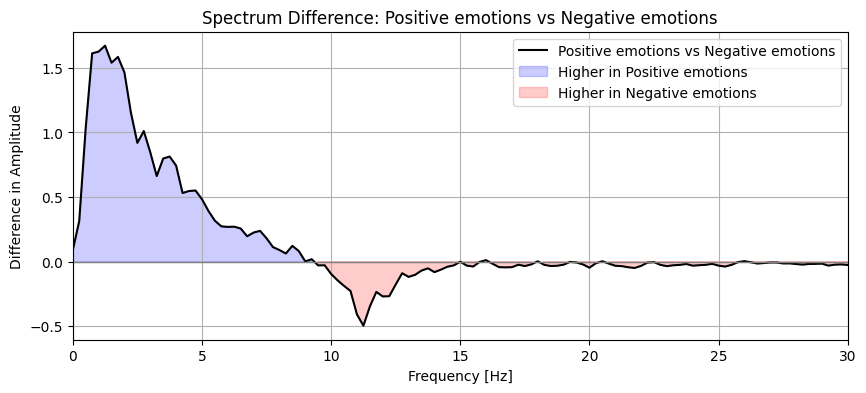

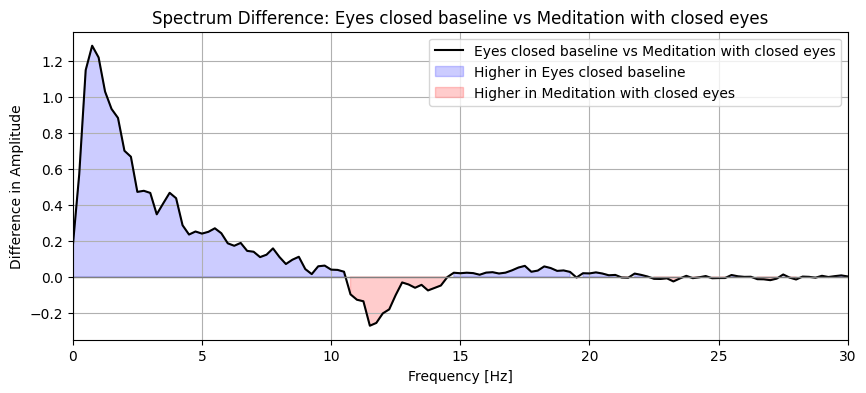

In [61]:
# 1. Позитивные vs негативные эмоции
compare_power_spectra(freq_axis_cut, 
                     avg_spectrum_positive[freq_mask], 
                     avg_spectrum_negative[freq_mask],
                     "Positive emotions",
                     "Negative emotions")

# 2. Проба1 vs медитация
compare_power_spectra(freq_axis_cut, 
                     avg_spectrum_probe1[freq_mask], 
                     avg_spectrum_meditation[freq_mask],
                     "Eyes closed baseline",
                     "Meditation with closed eyes")